# Creating a Scalable Recommender with Apache Spark & Elasticsearch

In this notebook, you will create a recommendation engine using Spark and Elasticsearch. Using some movie rating data,
you will train a collaborative filtering model in Spark and export the trained model to Elasticsearch. Once exported, 
you can test your recommendations by querying Elasticsearch and displaying the results.

### _Prerequisites_

The notebook assumes you have installed Elasticsearch, the Elasticsearch vector-scoring plugin, Apache Spark and the Elasticsearch Spark connector detailed in the [setup steps](https://github.com/MLnick/elasticsearch-spark-recommender-demo/tree/master#steps).

> _Optional:_

> In order to display the images in the recommendation demo, you will need to access [The Movie Database (TMdb) API](https://www.themoviedb.org/documentation/api). Please follow the [instructions](https://developers.themoviedb.org/3/getting-started) to get an API key.

## Overview

You will work through the following steps

1. Prepare the data
2. Use the Elasticsearch Spark connector to save it to Elasticsearch
3. Load ratings data and train a collaborative filtering recommendation model using Spark MLlib
3. Save the model to Elasticsearch
4. Show recommendations using Elasticsearch vector scoring plugin

## Step 1: Prepare the data

* This notebook uses the "small" version of the latest MovieLens movie rating dataset, containing about 100,000 ratings, 9,000 movies and 700 users
* The latest version of the data can be downloaded at https://grouplens.org/datasets/movielens/latest/
* Download the `ml-latest-small.zip` file and unzip it to a suitable location on your system.

The folder should contain a number of CSV files. We will be using the following files:
* `ratings.csv` - movie rating data
* `links.csv` - external database ids for each movie
* `movies.csv` - movie title and genres

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License. You may obtain
# a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
# WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
# License for the specific language governing permissions and limitations
# under the License.

# first import a few utility methods that we'll use later on
from IPython.display import Image, HTML, display

# check PySpark is running
spark

### Load rating and movie data

**Ratings**

The ratings data consists of around 100,000 ratings given by users to movies. Each row of the `DataFrame` consists of a `userId`, `movieId` and `timestamp` for the event, together with the `rating` given by the user to the movie

In [2]:
# if you unzipped the data to a different location than that specified in the Journey setup steps
# you can change the path below to point to the correct location
PATH_TO_DATA = "d:/Machine_Learning/Dataset/ml-latest-small/"
# load ratings data
ratings = spark.read.csv(PATH_TO_DATA + "ratings.csv", header=True, inferSchema=True)
ratings.cache()
print("Totally there are %i ratings in the dataset." % ratings.count())
print("Samples of rating:")
ratings.show(5)

Totally there are 100836 ratings in the dataset.
Samples of rating:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



You will see that the `timestamp` field is a UNIX timestamp in seconds. Elasticsearch takes timestamps in milliseconds, so you will use some `DataFrame` operations to convert the timestamps into milliseconds.

In [3]:
ratings = ratings.select(
    ratings.userId, ratings.movieId, ratings.rating, (ratings.timestamp.cast("long") * 1000).alias("timestamp"))
ratings.show(5)

+------+-------+------+------------+
|userId|movieId|rating|   timestamp|
+------+-------+------+------------+
|     1|      1|   4.0|964982703000|
|     1|      3|   4.0|964981247000|
|     1|      6|   4.0|964982224000|
|     1|     47|   5.0|964983815000|
|     1|     50|   5.0|964982931000|
+------+-------+------+------------+
only showing top 5 rows



**Movies**

The file `movies.csv` contains the `movieId`, `title` and `genres` for each movie. As you can see, the `genres` field is a bit tricky to use, as the genres are in the form of one string delimited by the `|` character: `Adventure|Animation|Children|Comedy|Fantasy`.

In [5]:
# load raw data from CSV
raw_movies = spark.read.csv(PATH_TO_DATA + "movies.csv", header=True, inferSchema=True)
print("Raw movie data:")
raw_movies.show(5, truncate=False)

Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



Create a `DataFrame` user-defined function (UDF) to extract this delimited string into a list of genres.

In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
# define a UDF to convert the raw genres string to an array of genres and lowercase
extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))
# test it out
raw_movies.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



Ok, that looks better!

You may also notice that the movie titles contain the year of release. It would be useful to have that as a field in your search index for filtering results (say you want to filter our recommendations to include only more recent movies).

Create a UDF to extract the release year from the title using a Python regular expression.

In [7]:
import re
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    
# test out our function
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

Ok the function works! Now create a new `DataFrame` with the cleaned-up titles, release dates and genres of the movies.

In [8]:
movies = raw_movies.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))
print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



Next, join the `links.csv` data to `movies` so that there is an id for _The Movie Database_ corresponding to each movie. You can use this id to retrieve movie poster images when displaying your recommendations later.

In [9]:
link_data = spark.read.csv(PATH_TO_DATA + "links.csv", header=True, inferSchema=True)
# join movies with links to get TMDB id
movie_data = movies.join(link_data, movies.movieId == link_data.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, link_data.tmdbId)
num_movies = movie_data.count()
print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

Cleaned movie data with tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+------------------------------------------------

> **_Optional_**

> Run the below cell to test your access to TMDb API. You should see the _Toy Story_ movie poster displayed inline.

> To install the Python package run `pip install tmdbsimple`

Successfully imported tmdbsimple!
+-------+--------------------+------------+--------+------+
|movieId|               title|release_date|  genres|tmdbId|
+-------+--------------------+------------+--------+------+
|      5|Father of the Bri...|        1995|[comedy]| 11862|
+-------+--------------------+------------+--------+------+



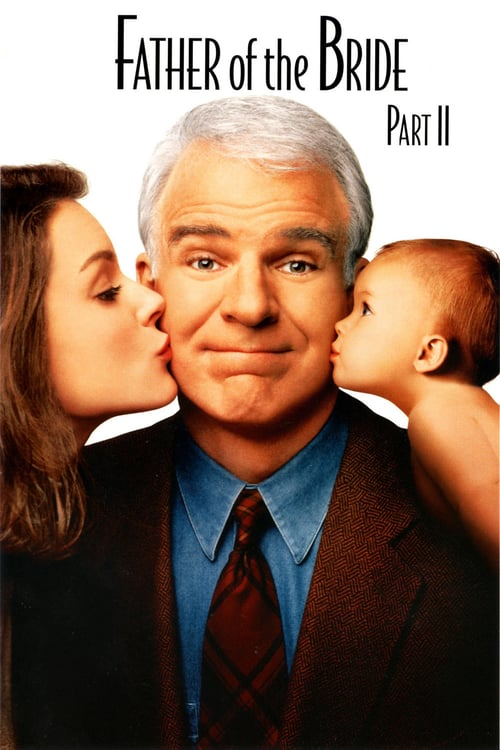

In [10]:
try:
    import tmdbsimple as tmdb
    # replace this variable with your actual TMdb API key
    tmdb.API_KEY = '338d7cb2fc8189133676369b3a093abc'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    #movie_id = movie_data.first().tmdbId
    movie_data.filter('movieid == 5').show()
    movie_id = movie_data.filter('movieid == 5').collect()[0].tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except Exception:
    print("Cannot import tmdbsimple, no movie posters will be displayed!")

## Step 2: Load data into Elasticsearch

Now that you have your dataset processed and prepared, you will load it into Elasticsearch.

_Note:_ for the purposes of this demo notebook you have started with an existing example dataset and will load that into Elasticsearch. In practice you may write your event data as well as user and item metadata from your application directly into Elasticsearch.

First test that your Elasticsearch instance is running and you can connect to it using the Python Elasticsearch client.

In [11]:
from elasticsearch import Elasticsearch

# test your ES instance is running
es = Elasticsearch()
es.info(pretty=True)

{'name': 'CGZh3S1',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'zx4RPqW3QJ2hW8k6L1VL5A',
 'version': {'number': '5.3.0',
  'build_hash': '3adb13b',
  'build_date': '2017-03-23T03:31:50.652Z',
  'build_snapshot': False,
  'lucene_version': '6.4.1'},
 'tagline': 'You Know, for Search'}

### Create an Elasticsearch index with mappings for users, movies and rating events

In Elasticsearch, an "index" is roughly similar to a "database", while a "document type" is roughly similar to a "table" in that database. The schema for a document type is called an index mapping.

While Elasticsearch supports dynamic mapping, it's advisable to specify the mapping explicitly when creating an index if you know what your data looks like.

For the purposes of your recommendation engine, this is also necessary so that you can specify a custom analyzer for the field that will hold the recommendation "model" (that is, the factor vectors). This will ensure the vector-scoring plugin will work correctly.

> _Note_ This notebook does not go into detail about the underlying scoring mechanism or the relevant Elasticsearch internals. See the talks and slides in the [Journey Links section](https://github.com/MLnick/elasticsearch-spark-recommender-demo/blob/master/README.md#links) for more detail.

__References:__
* [Create index request](https://www.elastic.co/guide/en/elasticsearch/reference/current/indices-create-index.html)
* [Delimited payload filter](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/analysis-delimited-payload-tokenfilter.html)
* [Term vectors](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/docs-termvectors.html#_term_information)
* [Mapping](https://www.elastic.co/guide/en/elasticsearch/reference/2.4/mapping.html)

> **_Optional_**

> If you are re-running the notebook and have previously created the `demo` index in Elasticsearch, you should first delete it by un-commenting and running the next cell, before running the index creation cell that follows.

In [12]:
if es.indices.exists(index='demo'):
    es.indices.delete(index="demo")

Now you're ready to create your index.

In [13]:
create_index = {
    "settings": {
        "analysis": {
            "analyzer": {
                # this configures the custom analyzer we need to parse vectors such that the scoring
                # plugin will work correctly
                "payload_analyzer": {
                    "type": "custom",
                    "tokenizer":"whitespace",
                    "filter":"delimited_payload_filter"
                }
            }
        }
    },
    "mappings": {
        "ratings": {
          # this mapping definition sets up the fields for the rating events
          "properties": {
                "timestamp": {
                    "type": "date"
                },
                "userId": {
                    "type": "integer"
                },
                "movieId": {
                    "type": "integer"
                },
                "rating": {
                    "type": "double"
                }
            }  
        },
        "users": {
            # this mapping definition sets up the metadata fields for the users
            "properties": {
                "userId": {
                    "type": "integer"
                },
                "@model": {
                    # this mapping definition sets up the fields for user factor vectors of our model
                    "properties": {
                        "factor": {
                            "type": "text",
                            "term_vector": "with_positions_offsets_payloads",
                            "analyzer" : "payload_analyzer"
                        },
                        "version": {
                            "type": "keyword"
                        },
                        "timestamp": {
                            "type": "date"
                        }
                    }
                }
            }
        },
        "movies": {
            # this mapping definition sets up the metadata fields for the movies
            "properties": {
                "movieId": {
                    "type": "integer"
                },
                "tmdbId": {
                    "type": "keyword"
                },
                "genres": {
                    "type": "keyword"
                },
                "release_date": {
                    "type": "date",
                    "format": "year"
                },
                "@model": {
                    # this mapping definition sets up the fields for movie factor vectors of our model
                    "properties": {
                        "factor": {
                            "type": "text",
                            "term_vector": "with_positions_offsets_payloads",
                            "analyzer" : "payload_analyzer"
                        },
                        "version": {
                            "type": "keyword"
                        },
                        "timestamp": {
                            "type": "date"
                        }
                    }
                }
            }
        }
    }
}
# create index with the settings and mappings above
es.indices.create(index="demo", body=create_index)

{'acknowledged': True, 'shards_acknowledged': True}

### Load Ratings and Movies DataFrames into Elasticsearch

First you will write the ratings data to Elasticsearch. Notice that you can simply use the Spark Elasticsearch connector to write a `DataFrame` with the native Spark datasource API by specifying `format("es")`

In [14]:
# write ratings data
ratings.write.format("es").save("demo/ratings")
# check write went ok
print("Dataframe count: %d" % ratings.count())
print("ES index count:  %d" % es.count(index="demo", doc_type="ratings")['count'])

Dataframe count: 100004
ES index count:  100004


In [15]:
# test things out by retrieving a few rating event documents from Elasticsearch
es.search(index="demo", doc_type="ratings", q="*", size=3)

{'took': 120,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'failed': 0},
 'hits': {'total': 100004,
  'max_score': 1.0,
  'hits': [{'_index': 'demo',
    '_type': 'ratings',
    '_id': 'AWaFLnYhBAdQoyujZqiP',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 1263,
     'rating': 2.0,
     'timestamp': 1260759151000}},
   {'_index': 'demo',
    '_type': 'ratings',
    '_id': 'AWaFLnYhBAdQoyujZqiV',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 1405,
     'rating': 1.0,
     'timestamp': 1260759203000}},
   {'_index': 'demo',
    '_type': 'ratings',
    '_id': 'AWaFLnYhBAdQoyujZqic',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 2968,
     'rating': 1.0,
     'timestamp': 1260759200000}}]}}

Since you've indexed the rating event data into Elasticsearch, you can use all the capabilities of a search engine to query the data. For example, you could count the number of ratings events in a given date range using Elasticsearch's date math in a query string:

In [16]:
es.count(index="demo", doc_type="ratings", q="timestamp:[2016-01-01 TO 2016-02-01]")

{'count': 290, '_shards': {'total': 5, 'successful': 5, 'failed': 0}}

Next write the movie metadata

In [17]:
# write movie data, specifying the DataFrame column to use as the id mapping
movie_data.write.format("es").option("es.mapping.id", "movieId").save("demo/movies")
# check load went ok
print("Movie DF count: %d" % movie_data.count())
print("ES index count: %d" % es.count(index="demo", doc_type="movies")['count'])

Movie DF count: 9125
ES index count: 9125


Again you can harness the power of search to query the movie metadata:

In [18]:
# test things out by searching for movies containing "matrix" in the title
es.search(index="demo", doc_type="movies", q="title:matrix", size=3)

{'took': 11,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'failed': 0},
 'hits': {'total': 3,
  'max_score': 6.852621,
  'hits': [{'_index': 'demo',
    '_type': 'movies',
    '_id': '2571',
    '_score': 6.852621,
    '_source': {'movieId': 2571,
     'title': 'Matrix, The',
     'release_date': '1999',
     'genres': ['action', 'sci-fi', 'thriller'],
     'tmdbId': 603}},
   {'_index': 'demo',
    '_type': 'movies',
    '_id': '6365',
    '_score': 5.7197466,
    '_source': {'movieId': 6365,
     'title': 'Matrix Reloaded, The',
     'release_date': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': 604}},
   {'_index': 'demo',
    '_type': 'movies',
    '_id': '6934',
    '_score': 5.7197466,
    '_source': {'movieId': 6934,
     'title': 'Matrix Revolutions, The',
     'release_date': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': 605}}]}}

## Step 3: Train a recommmender model on the ratings data

Your data is now stored in Elasticsearch and you will use the ratings data to build a collaborative filtering recommendation model.

[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) is a recommendation approach that is effectively based on the "wisdom of the crowd". It makes the assumption that, if two people share similar preferences, then the things that one of them prefers could be good recommendations to make to the other. In other words, if user A tends to like certain movies, and user B shares some of these preferences with user A, then the movies that user A likes, that user B _has not yet seen_, may well be movies that user B will also like.

In a similar manner, we can think about _items_ as being similar if they tend to be rated highly by the same people, on average. 

Hence these models are based on the combined, collaborative preferences and behavior of all users in aggregate. They tend to be very effective in practice (provided you have enough preference data to train the model). The ratings data you have is a form of _explicit preference data_, perfect for training collaborative filtering models.

### Alternating Least Squares

Alternating Least Squares (ALS) is a specific algorithm for solving a type of collaborative filtering model known as [matrix factorization (MF)](https://en.wikipedia.org/wiki/Matrix_decomposition). The core idea of MF is to represent the ratings as a _user-item ratings matrix_. In the diagram below you will see this matrix on the left (with users as _rows_ and movies as _columns_). The entries in this matrix are the ratings given by users to movies.

You may also notice that the matrix has _missing entries_ because not all users have rated all movies. In this situation we refer to the data as _sparse_.

![als-diagram.png](../doc/source/images/als-diagram.png)

MF methods aim to find two much smaller matrices (one representing the _users_ and the other the _items_) that, when multiplied together, re-construct the original ratings matrix as closely as possible. This is know as _factorizing_ the original matrix, hence the name of the technique.

The two smaller matrices are called _factor matrices_ (or _latent features_). The user and movie factor matrices are illustrated on the right in the diagram above. The idea is that each user factor vector is a compressed representation of the user's preferences and behavior. Likewise, each item factor vector is a compressed representation of the item. Once the model is trained, the factor vectors can be used to make recommendations, which is what you will do in the following sections.

__Further reading:__

* [Spark MLlib Collaborative Filtering](http://spark.apache.org/docs/latest/ml-collaborative-filtering.html)
* [Alternating Least Squares and collaborative filtering](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/)
* [Quora question on Alternating Least Squares](https://www.quora.com/What-is-the-Alternating-Least-Squares-method-in-recommendation-systems-And-why-does-this-algorithm-work-intuition-behind-this)

Fortunately, Spark's MLlib machine learning library has a scalable, efficient implementation of matrix factorization built in, which we can use to train our recommendation model. Next, you will use Spark's ALS to train a model on your ratings data from Elasticsearch.

In [19]:
ratings_from_es = spark.read.format("es").load("demo/ratings")
ratings_from_es.show(5)

+-------+------+-------------------+------+
|movieId|rating|          timestamp|userId|
+-------+------+-------------------+------+
|   1263|   2.0|2009-12-14 10:52:31|     1|
|   1405|   1.0|2009-12-14 10:53:23|     1|
|   2968|   1.0|2009-12-14 10:53:20|     1|
|   3671|   3.0|2009-12-14 10:51:57|     1|
|    153|   4.0|1996-06-21 19:10:41|     2|
+-------+------+-------------------+------+
only showing top 5 rows



In [21]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", regParam=0.01, rank=20, seed=12)
model = als.fit(ratings_from_es)
model.userFactors.show(5)
model.itemFactors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.3674726, 0.118...|
| 20|[-0.60201323, 0.8...|
| 30|[0.45107082, 0.01...|
| 40|[-0.23864046, -0....|
| 50|[0.44629014, 0.42...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.43729877, -0.3...|
| 20|[0.99712294, 1.34...|
| 30|[0.36094037, 0.10...|
| 40|[1.3377725, -0.00...|
| 50|[0.28212664, -0.2...|
+---+--------------------+
only showing top 5 rows



In [22]:
print('The rank of the factor matrix is %s.' % len(model.userFactors.first().features))
print('The structure of the factor matrix looks like:')
model.itemFactors.printSchema()

The rank of the factor matrix is 20.
The structure of the factor matrix looks like:
root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



## Step 4: Export ALS user and item factor vectors to Elasticsearch

Congratulations, you've trained a recommendation model! The next step is to export the model factors (shown in the `DataFrames` above) to Elasticsearch.

In order to store the model in the correct format for the index mappings set up earlier, you will need to create some utility functions. These functions will allow you to convert the raw vectors (which are equivalent to a Python list in the factor `DataFrames` above) to the correct _delimited string format_. This ensures Elasticsearch will parse the vector field in the model correctly using the delimited token filter custom analyzer you configured earlier.

You will also create a function to convert a vector and related metadata (such as the Spark model id and a timestamp) into a `DataFrame` field that matches the `model` field in the Elasticsearch index mapping.

### Utility functions for converting factor vectors

In [23]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, lit, current_timestamp, unix_timestamp

def convert_vector(x):
    '''Convert a list or numpy array to delimited token filter format'''
    return " ".join(["%s|%s" % (i, v) for i, v in enumerate(x)])

def reverse_convert(s):
    '''Convert a delimited token filter format string back to list format'''
    return  [float(f.split("|")[1]) for f in s.split(" ")]

def vector_to_struct(x, version, ts):
    '''Convert a vector to a SparkSQL Struct with string-format vector and version fields'''
    return (convert_vector(x), version, ts)

vector_struct = udf(vector_to_struct, \
                    StructType([StructField("factor", StringType(), True), \
                                StructField("version", StringType(), True),\
                                StructField("timestamp", LongType(), True)]))

In [24]:
# test out the vector conversion function
test_vec = model.userFactors.select("features").first().features
print(test_vec)
print()
print(convert_vector(test_vec))

[0.3674725890159607, 0.11864374577999115, 0.3943413197994232, 0.627119779586792, 0.1258048564195633, -0.43264928460121155, 0.607657253742218, -0.002352567855268717, -0.0375259667634964, -0.07540702074766159, 0.1594085991382599, -0.8177066445350647, 0.5343821048736572, -0.6135174632072449, 0.5194279551506042, 0.28479066491127014, -0.14081591367721558, -0.007298605982214212, -0.26084643602371216, -0.5528038144111633]

0|0.3674725890159607 1|0.11864374577999115 2|0.3943413197994232 3|0.627119779586792 4|0.1258048564195633 5|-0.43264928460121155 6|0.607657253742218 7|-0.002352567855268717 8|-0.0375259667634964 9|-0.07540702074766159 10|0.1594085991382599 11|-0.8177066445350647 12|0.5343821048736572 13|-0.6135174632072449 14|0.5194279551506042 15|0.28479066491127014 16|-0.14081591367721558 17|-0.007298605982214212 18|-0.26084643602371216 19|-0.5528038144111633


### Convert factor vectors to [factor, version, timestamp] form and write to Elasticsearch

In [25]:
ver = model.uid
ts = unix_timestamp(current_timestamp())
movie_vectors = model.itemFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
movie_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)
user_vectors = model.userFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
user_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)

+---+--------------------+--------------------+----------+
| id|              factor|             version| timestamp|
+---+--------------------+--------------------+----------+
| 10|0|0.4372987747192...|ALS_4b2caf99d14ee...|1539832829|
| 20|0|0.9971229434013...|ALS_4b2caf99d14ee...|1539832829|
| 30|0|0.3609403669834...|ALS_4b2caf99d14ee...|1539832829|
| 40|0|1.3377724885940...|ALS_4b2caf99d14ee...|1539832829|
| 50|0|0.2821266353130...|ALS_4b2caf99d14ee...|1539832829|
+---+--------------------+--------------------+----------+
only showing top 5 rows

+---+--------------------+--------------------+----------+
| id|              factor|             version| timestamp|
+---+--------------------+--------------------+----------+
| 10|0|0.3674725890159...|ALS_4b2caf99d14ee...|1539832831|
| 20|0|-0.602013230323...|ALS_4b2caf99d14ee...|1539832831|
| 30|0|0.4510708153247...|ALS_4b2caf99d14ee...|1539832831|
| 40|0|-0.238640457391...|ALS_4b2caf99d14ee...|1539832831|
| 50|0|0.4462901353836...|ALS_4

In [26]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "update" write mode for ES, since you want to update new fields only
# - "append" write mode for Spark
movie_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("demo/movies", mode="append")

In [27]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "index" write mode for ES, since you have not written to the user index previously
# - "append" write mode for Spark
user_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "index") \
    .save("demo/users", mode="append")

### Check the data  was written correctly

You can search for a movie to see if the model factor vector was written correctly. You should see a `'@model': {'factor': '0|...` field in the returned movie document.

In [28]:
# search for a particular sci-fi movie
es.search(index="demo", doc_type="movies", q="star wars phantom menace", size=1)['hits']['hits'][0]

{'_index': 'demo',
 '_type': 'movies',
 '_id': '2628',
 '_score': 8.91483,
 '_source': {'movieId': 2628,
  'title': 'Star Wars: Episode I - The Phantom Menace',
  'release_date': '1999',
  'genres': ['action', 'adventure', 'sci-fi'],
  'tmdbId': 1893,
  '@model': {'factor': '0|0.06697040051221848 1|0.5315472483634949 2|0.6013755798339844 3|0.07912897318601608 4|1.0341451168060303 5|-1.1147366762161255 6|0.3860779404640198 7|-1.9866496324539185 8|0.8514615297317505 9|0.0678836777806282 10|0.5278503894805908 11|-0.8509363532066345 12|0.5262570977210999 13|0.3691430389881134 14|-0.12169963121414185 15|2.794771909713745 16|0.17998555302619934 17|-1.0284113883972168 18|-0.4195162355899811 19|-1.2251869440078735',
   'version': 'ALS_4b2caf99d14eec60d7a1',
   'timestamp': 1539832836},
  'id': 2628}}

## Step 5: Recommend using Elasticsearch!

Now that you have loaded your recommendation model into Elasticsearch, you will generate some recommendations.
First, you will need to create a few utility functions for:

* Fetching movie posters from TMdb API (optional)
* Constructing the Elasticsearch [function score query](https://www.elastic.co/guide/en/elasticsearch/reference/5.3/query-dsl-function-score-query.html) to generate recommendations from your factor model
* Given a movie, use this query to find the movies most similar to it
* Given a user, use this query to find the movies with the highest predicted rating, to recommend to the user
* Display the results as an HTML table in Jupyter

In [29]:
from IPython.display import Image, HTML, display

def get_poster_url(id):
    """Fetch movie poster image URL from TMDb API given a tmdbId"""
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        import tmdbsimple as tmdb
        from tmdbsimple import APIKeyError
        try:
            movie = tmdb.Movies(id).info()
            poster_url = IMAGE_URL + \
                movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"
    
    
def fn_query(query_vec, q="*", cosine=False):
    """
    Construct an Elasticsearch function score query.
    
    The query takes as parameters:
        - the field in the candidate document that contains the factor vector
        - the query vector
        - a flag indicating whether to use dot product or cosine similarity (normalized dot product) for scores
        
    The query vector passed in will be the user factor vector (if generating recommended movies for a user)
    or movie factor vector (if generating similar movies for a given movie)
    """
    return {
    "query": {
        "function_score": {
            "query" : { 
                "query_string": {
                    "query": q
                }
            },
            "script_score": {
                "script": {
                        "inline": "payload_vector_score",
                        "lang": "native",
                        "params": {
                            "field": "@model.factor",
                            "vector": query_vec,
                            "cosine" : cosine
                        }
                    }
            },
            "boost_mode": "replace"
        }
    }
}


def get_similar(the_id, q="*", num=10, index="demo", dt="movies"):
    """
    Given a movie id, execute the recommendation function score query to find similar movies, 
    ranked by cosine similarity
    """
    response = es.get(index=index, doc_type=dt, id=the_id)
    src = response['_source']
    if '@model' in src and 'factor' in src['@model']:
        raw_vec = src['@model']['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec)
        q = fn_query(query_vec, q=q, cosine=True)
        results = es.search(index, dt, body=q)
        hits = results['hits']['hits']
        return src, hits[1:num+1]
    
    
def get_user_recs(the_id, q="*", num=10, index="demo"):
    """
    Given a user id, execute the recommendation function score query to find top movies, 
    ranked by predicted rating
    """
    response = es.get(index=index, doc_type="users", id=the_id)
    src = response['_source']
    if '@model' in src and 'factor' in src['@model']:
        raw_vec = src['@model']['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec)
        q = fn_query(query_vec, q=q, cosine=False)
        results = es.search(index, "movies", body=q)
        hits = results['hits']['hits']
        return src, hits[:num]

def get_movies_for_user(the_id, num=10, index="demo"):
    """
    Given a user id, get the movies rated by that user, from highest- to lowest-rated.
    """
    response = es.search(index=index, doc_type="ratings", q="userId:%s" % the_id, size=num, sort=["rating:desc"])
    hits = response['hits']['hits']
    ids = [h['_source']['movieId'] for h in hits]
    movies = es.mget(body={"ids": ids}, index=index, doc_type="movies", _source_include=['tmdbId', 'title'])
    movies_hits = movies['docs']
    tmdbids = [h['_source'] for h in movies_hits]
    return tmdbids

            
def display_user_recs(the_id, q="*", num=10, num_last=10, index="demo"):
    user, recs = get_user_recs(the_id, q, num, index)
    user_movies = get_movies_for_user(the_id, num_last, index)
    # check that posters can be displayed
    first_movie = user_movies[0]
    first_im_url = get_poster_url(first_movie['tmdbId'])
    if first_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if first_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. \
                     No movie posters will be displayed!</i>"))
        
    # display the movies that this user has rated highly
    display(HTML("<h2>Get recommended movies for user id %s</h2>" % the_id))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        movie_im_url = get_poster_url(movie['tmdbId'])
        movie_title = movie['title']
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (movie_title, movie_im_url)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
    # now display the recommended movies for the user
    display(HTML("<br>"))
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" \
            % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))

    
def display_similar(the_id, q="*", num=10, index="demo", dt="movies"):
    """
    Display query movie, together with similar movies and similarity scores, in a table
    """
    movie, recs = get_similar(the_id, q, num, index, dt)
    q_im_url = get_poster_url(movie['tmdbId'])
    if q_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if q_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. \
            No movie posters will be displayed!</i>"))
        
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(HTML("<h4>%s</h4>" % movie['title']))
    if q_im_url != "NA":
        display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>People who liked this movie also liked these:</h2>"))
    sim_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        sim_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" \
            % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

Now, you're ready to generate some recommendations.

### 5(a) Find similar movies for a given movie

To start, you can find movies that are _similar_ to a given movie. This similarity score is computed from the model factor vectors for each movie. Recall that the ALS model you trained earlier is a collaborative filtering model, so the similarity between movie vectors will be based on the _rating co-occurrence_ of the movies. In other words, two movies that tend to be rated highly by a user will tend to be more similar. It is common to use the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) of the movie factor vectors as a measure of the similarity between two movies.

Using this similarity you can show recommendations along the lines of _people who liked this movie also liked these_.

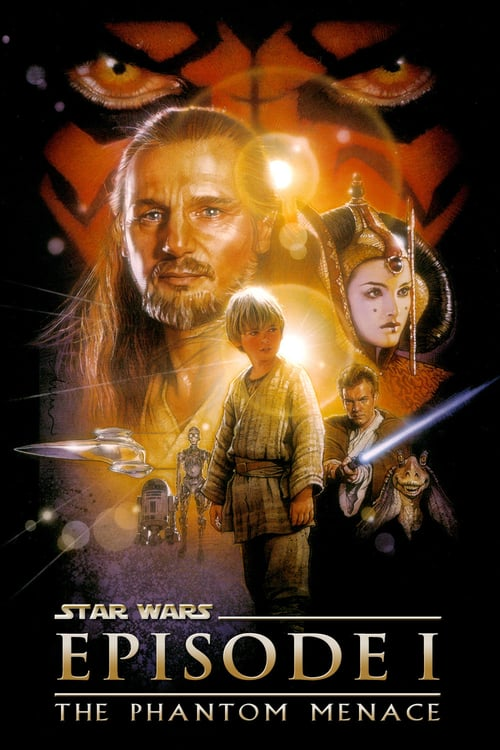

In [30]:
display_similar(2628, num=5)

So we see that people who like Star Wars tend like other sci-fi movies (including other Star Wars films), as well as some action and drama.

> _Note_ since we are using a very small dataset, results may not be as good as those for the same model trained on a larger dataset.

Now you will see the power and flexibility that comes from using a search engine to generate recommendations. Elasticsearch allows you to tweak the results returned by the recommendation query using any standard search query or filter - from free text search through to filters based on time and geo-location (or any other piece of metadata you can think of).

For example, perhaps you want to remove any movies with "matrix" in the title from the recommendations. You can do this by simply passing a valid Elasticsearch query string to the recommendation function.

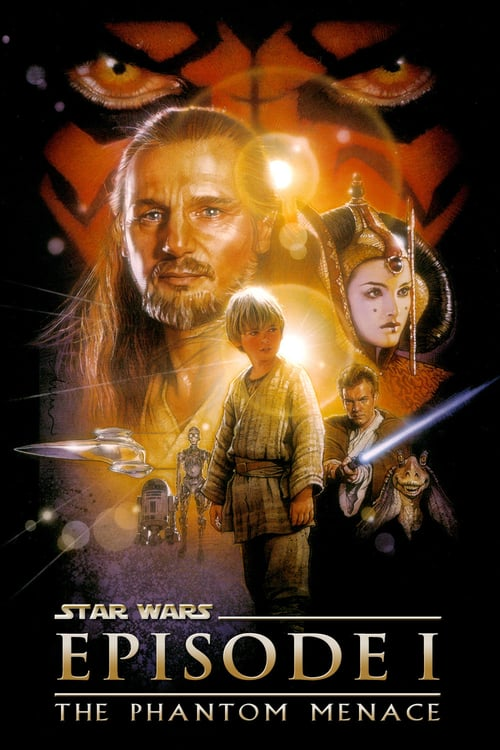

In [31]:
display_similar(2628, num=5, q="title:(NOT matrix)")

Or you may want to ensure that only valid children's movies are shown to young viewers.

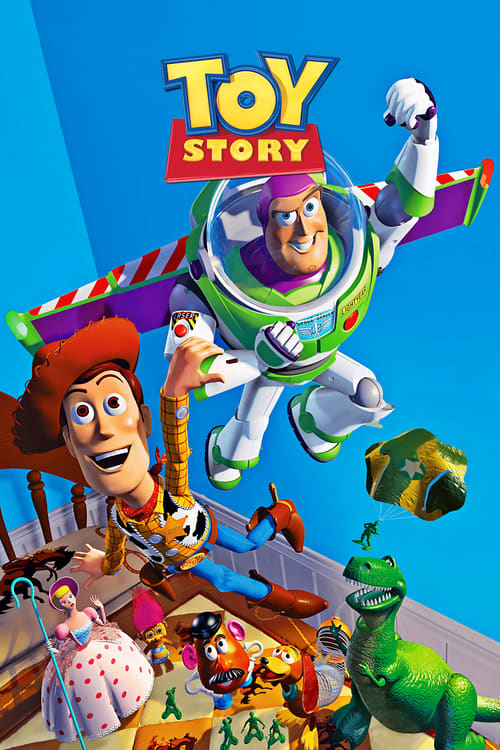

In [32]:
display_similar(1, num=5, q="genres:children")

Feel free to check out the documentation for the Elasticsearch [query string query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-query-string-query.html) and play around with the various queries you can construct by passing in a query string as `q` in the recommendation function above!

### 5(b) Find movies to recommend to a user

Now, you're ready to generate some movie recommendations, personalized for a specific user.

Given a user, you can recommend movies to that user based on the predicted ratings from your model. In a similar manner to the similar movie recommendations, this predicted rating score is computed from the model factor vector for the user and the factor vectors for each movie. Recall that the collaborative filtering model means that, at a high level, we will recommend movies _liked by other users who liked the same movies as the given user_.

In [33]:
display_user_recs(12, num=5, num_last=5)

Again, note that since we are using a very small dataset, the results may not be too good. However, we can see that this user seems to like some sci-fi, some horror and some comedy films. The recommended movies fall broadly into these categories and seem to be somewhat reasonable.

Next, you can again apply the power of Elasticsearch's filtering capabilities to your recommendation engine. Let's say you only want to recommend more recent movies (say, from the past 5 years). This can be done by adding a date math query to the recommendation function score query.

In [34]:
display_user_recs(12, num=5, num_last=5, q="release_date:[2012 TO *]")

You can see that the recommendation include only recent movies, and this time they seem to be heavily tilted to sci-fi and fantasy genres.

As you did with the similar movies recommendations, feel free to play around with the various queries you could pass into the user recommendation query.